<div align="center">
    <img src="https://dask.org/_images/dask_horizontal_white_no_pad_dark_bg.png" width=600/>
    <h2><span style="font:tradegothic; color:gray">Parallel computing in Python with Dask</span></h2>
    <h5><span style="font:tradegothic; color:gray">Hillary Scannell – August 3, 2021</span></h5>
    <hr>
</div>

<div align="left" style="font-size:20px;">
    <h3>What we will cover:</h3>
     <hr>
</div>
<div align="left" style="font-size:18px;">
    <ul>
      <li>What is Dask and when should it be used?</li> 
      <br><li>Dask Collections</li>
      <br><li>Dynamic task scheduling and task graphs</li> 
      <br><li>Best practices</li> 
    </ul> 
</div>

<div align="center">
<h1><span style="font:tradegothic; color:gray">PyData Stack</span></h1>
<hr>
    <img src="https://devopedia.org/images/article/60/7938.1587985662.jpg" width=100%/>
</div>

Notes:
- For scientific computing in Python
- interoperable collection of tools for data analysis, visualization, statistical inference, machine learning, interactive computing

<div align="left" style="font-size:20px;">
    <h3>Why Dask?</h3>
     <hr>
</div>
<div align="left" style="font-size:18px;">
    <ul>
      <li>Familiar and flexible library for parallel computing in Python using NumPy arrays and Pandas DataFrame objects</li> 
      <br><li>Designed to scale analyses up or down to multi-core machines and distributed clusters</li>
      <br><li>Breaks up different parts of a task among multiple processors will help reduce the amount of time to run a program</li> 
      <br><li>Operates with low overhead, latency and serializaiton == Fast  </li> 
      <br><li>Interactive: provides feedback and diagnostics</li> 
    </ul> 
</div>

<div align="left">
<h1><span style="font:tradegothic; color:gray">Dask Collections</span></h1>
<h4><span>Collections extend common Python interfaces in larger-than-memory environments.</span></h4>
    <pre>dask.array</pre><pre>dask.dataframe</pre>
<hr>
</div>

<div align="left">
<h3><span style="font:tradegothic; color:black">Dask.array</span></h3>
    <p>Dask Array implements a subset of the NumPy ndarray interface using blocked algorithms, cutting up the large array into many small arrays. This lets us compute on arrays larger than memory using all of our cores. We coordinate these blocked algorithms using Dask graphs.</p>
    <img src="https://docs.dask.org/en/latest/_images/dask-array-black-text.svg" width=50%/>
</div>

### Create and Connect to Dask Distributed Cluster
This gives insight on the computation

In [20]:
from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
cluster = gateway.new_cluster() # new Dask cluster
cluster.adapt(minimum=1, maximum=30) # cluster will automatically resize itself based on the workload
cluster

In [21]:
client = Client(cluster) # creates a client so computations using Dask will be executed on the cluster.
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.57fc876c54964d1bae8f0d836e381d46 Dashboard: /services/dask-gateway/clusters/prod.57fc876c54964d1bae8f0d836e381d46/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [50]:
import dask.array as da
x = da.random.random((10000, 10000), chunks=(1000, 1000)) # Many numpy arrays that are loaded lazily in parallel
x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [51]:
y = x + x.T
z = y[::2, :].mean(axis=1)
z

dask.array<mean_agg-aggregate, shape=(5000,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>

In [52]:
z.compute()

array([1.00246172, 0.9969768 , 1.00284349, ..., 1.01185554, 0.99796077,
       1.00721055])

### Persist data in memory

In [53]:
y = y.persist()

### Creating Dask Arrays

In [47]:
import dask.array as dda

y = np.random.random((10000, 10000))
print(f'''NumPy array shape = {y.shape}''')

dask_it = dda.from_array(y, chunks=(100, 100))
dask_it

NumPy array shape = (10000, 10000)


dask.array<array, shape=(10000, 10000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

<div align="left">
<h3><span style="font:tradegothic; color:black">Dask.DataFrame</span></h3>
    <p>A Dask DataFrame is a large parallel DataFrame composed of many smaller Pandas DataFrames, split along the index. These Pandas DataFrames may live on disk for larger-than-memory computing on a single machine, or on many different machines in a cluster. One Dask DataFrame operation triggers many operations on the constituent Pandas DataFrames.</p>
        <img src="https://docs.dask.org/en/latest/_images/dask-dataframe.svg" width=30%/>

</div>

In [64]:
import dask
import dask.dataframe as dd

# Create a random timeseries of data from every 10 seconds of the year 2000
df = dask.datasets.timeseries()
df # Dask DataFrames are lazy, therefore no data is printed, only dtypes are known

,id,name,x,y
npartitions=30,,,,
2000-01-01,int64,object,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


In [67]:
# Use Pandas Operations
df2 = df[df.y > 0]
df3 = df2.groupby('name').x.std()
df3

Dask Series Structure:
npartitions=1
    float64
        ...
Name: x, dtype: float64
Dask Name: sqrt, 157 tasks

In [70]:
computed_df = df3.compute()
print(type(computed_df))
print(computed_df)

<class 'pandas.core.series.Series'>
name
Alice       0.577532
Bob         0.575748
Charlie     0.578512
Dan         0.577564
Edith       0.578275
Frank       0.578751
George      0.577836
Hannah      0.576825
Ingrid      0.577651
Jerry       0.576499
Kevin       0.576373
Laura       0.580896
Michael     0.578900
Norbert     0.577430
Oliver      0.577734
Patricia    0.576535
Quinn       0.578605
Ray         0.576412
Sarah       0.574807
Tim         0.578140
Ursula      0.576836
Victor      0.575329
Wendy       0.578169
Xavier      0.576557
Yvonne      0.575212
Zelda       0.575230
Name: x, dtype: float64


In [71]:
df = df.persist()

In [73]:
df[['x', 'y']].resample('1h').mean().head()

,x,y
timestamp,,
2000-01-01 00:00:00,-0.006483,-0.010736
2000-01-01 01:00:00,-0.009191,0.005296
2000-01-01 02:00:00,0.013725,0.009481
2000-01-01 03:00:00,0.010365,0.012484
2000-01-01 04:00:00,0.009275,-0.002505


<AxesSubplot:xlabel='timestamp'>

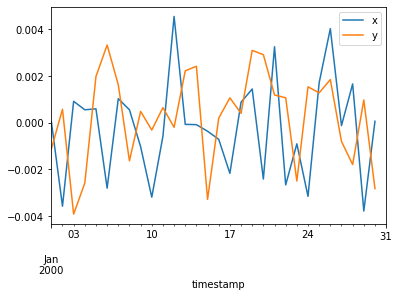

In [75]:
df[['x', 'y']].resample('24h').mean().compute().plot()

<div align="center" style="font-size:20px;">
<h3><span style="font:tradegothic; color:black">Xarray with Dask Arrays</span></h3>
<img src="https://examples.dask.org/_images/dataset-diagram-logo.png" width=50%/>

</div>

In [84]:
import s3fs
import xarray as xr

endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},) 

path = "Pangeo/pangeo-forge/noaa_oisst/v2.1-avhrr.zarr"
ds = xr.open_zarr(fs_osn.get_mapper(path), consolidated=True).resample(time='MS').mean()
ds

,Array,Chunk
Bytes,1.98 GB,4.15 MB
Shape,"(478, 1, 720, 1440)","(1, 1, 720, 1440)"
Count,4524 Tasks,478 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.98 GB,4.15 MB
Shape,"(478, 1, 720, 1440)","(1, 1, 720, 1440)"
Count,4524 Tasks,478 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [85]:
da = ds.sst.isel(zlev=0)
da.data

dask.array<getitem, shape=(478, 720, 1440), dtype=float32, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>

Call `.compute()` or `.load()` when you want the xarray.DataArray stored as a NumPy array.

In [87]:
da2 = da.groupby('time.month').mean('time')
da3 = da - da2
# computed_da = da3.compute()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(


Slicing by label is trivial and entirely lazy.